In [162]:
import control as ct
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

In [163]:
# Define the system matrices
A = np.block([[np.zeros((3, 3)), np.eye(3), np.zeros((3, 3))],
              [np.zeros((3, 3)), np.zeros((3, 3)), -np.eye((3))],
              [np.zeros((3, 3)), np.zeros((3, 3)), np.zeros((3, 3))]])
B = np.block([[np.zeros((3, 3))],
              [np.eye(3)],
              [np.zeros((3, 3))]])
C = np.block([[np.eye(3), np.zeros((3, 6))]]) # the z is assumed to come from altimeter/barometer
D = 0

sys = ct.ss(A, B, C, D)
obs = ct.obsv(sys.A, sys.C)
print("Obs: ", np.linalg.matrix_rank(obs))

A.shape,B.shape
comb = np.block([[A, B], [np.zeros((12-A.shape[0], 12))]])
dt = 0.005
dMexp = la.expm(comb*dt)
Ad = dMexp[:A.shape[0], :A.shape[0]]
Bd = dMexp[:A.shape[0], A.shape[0]:]
assert Ad.shape == A.shape
assert Bd.shape == B.shape

Obs:  9


In [164]:
# generate trajectory p(t)
end = 5
samples = end*100
np.random.seed(0)
p = np.vstack((np.sin(np.linspace(0, end, samples)),
               np.cos(np.linspace(0, end, samples)),
               np.ones(samples)))  # delta p
v = np.vstack((np.cos(np.linspace(0, end, samples)),
               -np.sin(np.linspace(0, end, samples)),
               np.zeros(samples)))  # delta v
a_bias = np.array([[0.1, 0.2, 0.3]]).T
a_noise = 0.2*np.random.randn(3, samples)
a = np.vstack((-np.sin(np.linspace(0, end, samples)),
               -np.cos(np.linspace(0, end, samples)),
               np.zeros(samples),)) + a_bias + a_noise
yp = p + 0.05*np.random.randn(3, samples)

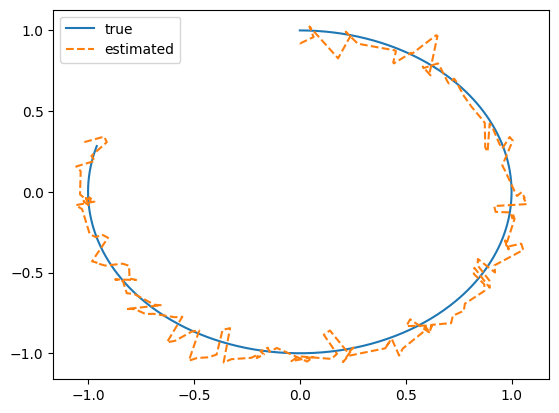

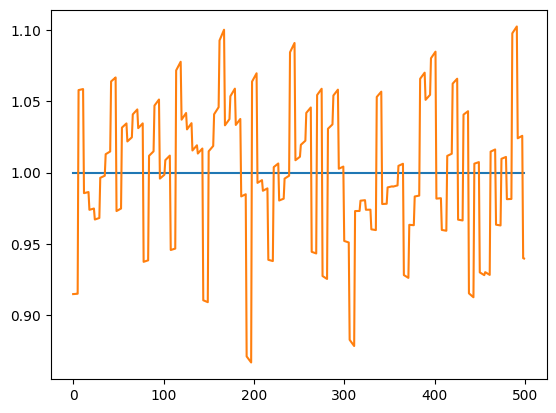

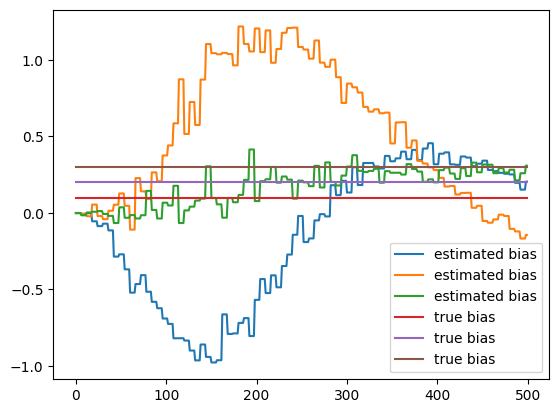

In [165]:
# Define the system matrices
F = Ad

H = np.array(C)

# Process noise covariance
Q = np.diag([1, 1, 1, 1, 1, 1, 0, 0, 0])

# Measurement noise covariance
R = np.diag([0.05, 0.05, 0.05])

# Initial state estimate
x_hat = np.zeros((9, 1))

# Initial error covariance
P = np.diag([10, 10, 10, 10, 10, 10, 1000, 1000, 1000])

record = np.zeros((len(p[0]), 9))

# Kalman Filter loop
for i in range(len(p[0])):
    # Predict step
    x_hat = F @ x_hat + Bd @ a[:, i].reshape(-1, 1)
    P = F @ P @ F.T + Q

    # Update step
    if i % 6 == 0:
        K = P @ H.T @ np.linalg.inv(H @ P @ H.T + R)
        x_hat = x_hat + K @ (yp[:, i].reshape(-1, 1) - H @ x_hat)
        P = (np.eye(9) - K @ H) @ P
    record[i, :] = x_hat.T

plt.plot(p[0], p[1], label='true')
plt.plot(record[:, 0], record[:, 1], label='estimated', linestyle='dashed')
plt.legend()
plt.figure()
plt.plot(np.arange(len(p[0])), p[2], label='true height')
plt.plot(np.arange(len(p[0])), record[:, 2], label='estimated height')
plt.figure()
plt.plot(record[:, -3:], label='estimated bias')
plt.plot((a_bias*np.ones(len(record))).T, label='true bias')
plt.legend()

In [166]:
rmse = np.sqrt(np.mean((p[:3, :].T - record[:, :3])**2, axis=0))
rmae = np.mean(np.abs(p[:3, :].T - record[:, :3]), axis=0)
rmse, rmae

(array([0.052, 0.064, 0.049]), array([0.043, 0.050, 0.040]))